# Object segmentations with FastSAM and OpenVINO
[The Fast Segment Anything Model (FastSAM)](https://docs.ultralytics.com/models/fast-sam/) is a real-time CNN-based model that can segment any object within an image based on various user prompts. `Segment Anything` task is designed to make vision tasks easier by providing an efficient way to identify objects in an image. FastSAM significantly reduces computational demands while maintaining competitive performance, making it a practical choice for a variety of vision tasks.

FastSAM is a model that aims to overcome the limitations of the [Segment Anything Model (SAM)](https://docs.ultralytics.com/models/sam/), which is a Transformer model that requires significant computational resources. FastSAM tackles the segment anything task by dividing it into two consecutive stages: all-instance segmentation and prompt-guided selection. 

In the first stage, [`YOLOv8-seg`](https://docs.ultralytics.com/tasks/segment/) is used to produce segmentation masks for all instances in the image. In the second stage, FastSAM outputs the region-of-interest corresponding to the prompt.

![pipeline](https://user-images.githubusercontent.com/26833433/248551984-d98f0f6d-7535-45d0-b380-2e1440b52ad7.jpg)


#### Table of contents:

- [Prerequisites](#Prerequisites)
    - [Install requirements](#Install-requirements)
    - [Imports](#Imports)
- [FastSAM in Ultralytics](#FastSAM-in-Ultralytics)
- [Convert the model to OpenVINO Intermediate representation (IR) format](#Convert-the-model-to-OpenVINO-Intermediate-representation-(IR)-format)
- [Embedding the converted models into the original pipeline](#Embedding-the-converted-models-into-the-original-pipeline)
    - [Select inference device](#Select-inference-device)
    - [Adapt OpenVINO models to the original pipeline](#Adapt-OpenVINO-models-to-the-original-pipeline)
- [Optimize the model using NNCF Post-training Quantization API](#Optimize-the-model-using-NNCF-Post-training-Quantization-API)
    - [Compare the performance of the Original and Quantized Models](#Compare-the-performance-of-the-Original-and-Quantized-Models)
- [Try out the converted pipeline](#Try-out-the-converted-pipeline)



## Prerequisites
[back to top ⬆️](#Table-of-contents:)


### Install requirements
[back to top ⬆️](#Table-of-contents:)


In [ ]:
%pip install -q "ultralytics==8.0.200" onnx --extra-index-url https://download.pytorch.org/whl/cpu
%pip install -q "openvino-dev>=2024.0.0"
%pip install -q "nncf>=2.6.0"
%pip install -q "gradio>=4.13"

### Imports
[back to top ⬆️](#Table-of-contents:)


In [2]:
import ipywidgets as widgets
from pathlib import Path

import openvino as ov
import torch
from PIL import Image, ImageDraw
from ultralytics import FastSAM

import urllib.request
# Fetch skip_kernel_extension module
urllib.request.urlretrieve(
    url='https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/utils/skip_kernel_extension.py',
    filename='skip_kernel_extension.py'
)
# Fetch `notebook_utils` module
urllib.request.urlretrieve(
    url='https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/utils/notebook_utils.py',
    filename='notebook_utils.py'
)
from notebook_utils import download_file
%load_ext skip_kernel_extension

## FastSAM in Ultralytics
[back to top ⬆️](#Table-of-contents:)

To work with [Fast Segment Anything Model](https://github.com/CASIA-IVA-Lab/FastSAM) by `CASIA-IVA-Lab`, we will use the [Ultralytics package](https://docs.ultralytics.com/). Ultralytics package exposes the `FastSAM` class, simplifying the model instantiation and weights loading. The code below demonstrates how to initialize a `FastSAM` model and generate a segmentation map.

In [3]:
model_name = "FastSAM-x"
model = FastSAM(model_name)

# Run inference on an image
image_uri = "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/coco_bike.jpg"
image_uri = download_file(image_uri)
results = model(image_uri, device="cpu", retina_masks=True, imgsz=1024, conf=0.6, iou=0.9)

'coco_bike.jpg' already exists.



image 1/1 /home/ea/work/openvino_notebooks/notebooks/fast-segment-anything/coco_bike.jpg: 768x1024 37 objects, 781.8ms
Speed: 4.2ms preprocess, 781.8ms inference, 37.7ms postprocess per image at shape (1, 3, 768, 1024)


The model returns segmentation maps for all the objects on the image. Observe the results below.

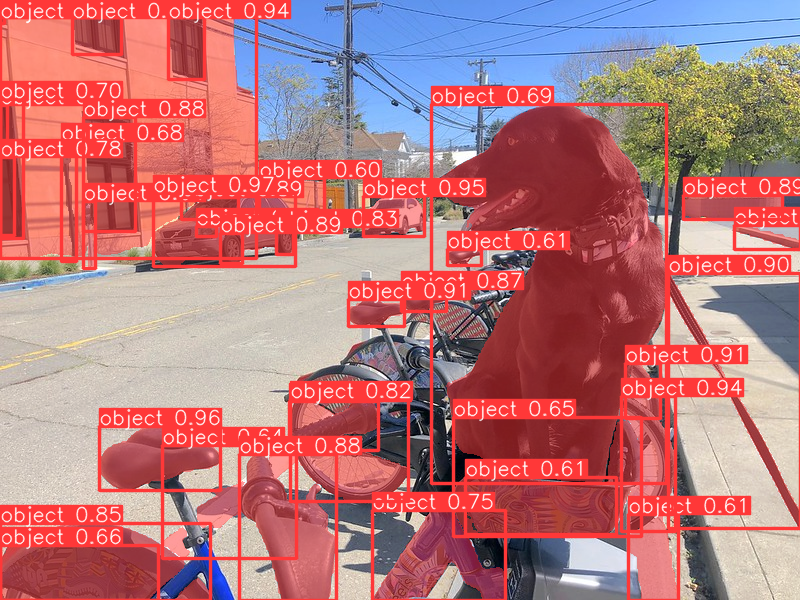

In [4]:
Image.fromarray(results[0].plot()[..., ::-1])

## Convert the model to OpenVINO Intermediate representation (IR) format
[back to top ⬆️](#Table-of-contents:)

The Ultralytics Model export API enables conversion of PyTorch models to OpenVINO IR format. Under the hood it utilizes the `openvino.convert_model` method to acquire OpenVINO IR versions of the models. The method requires a model object and example input for model tracing. The FastSAM model itself is based on YOLOv8 model.

In [5]:
# instance segmentation model
ov_model_path = Path(f"{model_name}_openvino_model/{model_name}.xml")
if not ov_model_path.exists():
    ov_model = model.export(format="openvino", dynamic=False, half=False)


## Embedding the converted models into the original pipeline
[back to top ⬆️](#Table-of-contents:)

OpenVINO™ Runtime Python API is used to compile the model in OpenVINO IR format. The [Core](https://docs.openvino.ai/2024/api/ie_python_api/_autosummary/openvino.runtime.Core.html) class provides access to the OpenVINO Runtime API. The `core` object, which is an instance of the `Core` class represents the API and it is used to compile the model.

In [6]:
core = ov.Core()

#### Select inference device
[back to top ⬆️](#Table-of-contents:)

Select device that will be used to do models inference using OpenVINO from the dropdown list:

In [7]:
device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value="AUTO",
    description="Device:",
    disabled=False,
)

device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

### Adapt OpenVINO models to the original pipeline
[back to top ⬆️](#Table-of-contents:)

Here we create wrapper classes for the OpenVINO model that we want to embed in the original inference pipeline.
Here are some of the things to consider when adapting an OV model:
 - Make sure that parameters passed by the original pipeline are forwarded to the compiled OV model properly; sometimes the OV model uses only a portion of the input arguments and some are ignored, sometimes you need to convert the argument to another data type or unwrap some data structures such as tuples or dictionaries.
 - Guarantee that the wrapper class returns results to the pipeline in an expected format. In the example below you can see how we pack OV model outputs into a tuple of `torch` tensors.
 - Pay attention to the model method used in the original pipeline for calling the model - it may be not the `forward` method! In this example, the model is a part of a `predictor` object and called as and object, so we need to redefine the magic `__call__` method.

In [8]:
class OVWrapper:
    def __init__(self, ov_model, device="CPU", stride=32, ov_config=None) -> None:
        ov_config = ov_config or {}
        self.model = core.compile_model(ov_model, device, ov_config)

        self.stride = stride
        self.pt = False
        self.fp16 = False
        self.names = {0: "object"}

    def __call__(self, im, **_):
        result = self.model(im)
        return torch.from_numpy(result[0]), torch.from_numpy(result[1])

Now we initialize the wrapper objects and load them to the FastSAM pipeline.

In [9]:
ov_config = {}
if "GPU" in device.value or ("AUTO" in device.value and "GPU" in core.available_devices):
    ov_config = {"GPU_DISABLE_WINOGRAD_CONVOLUTION": "YES"}

wrapped_model = OVWrapper(ov_model_path, device=device.value, stride=model.predictor.model.stride, ov_config=ov_config)
model.predictor.model = wrapped_model

ov_results = model(image_uri, device=device.value, retina_masks=True, imgsz=1024, conf=0.6, iou=0.9)


image 1/1 /home/ea/work/openvino_notebooks/notebooks/fast-segment-anything/coco_bike.jpg: 1024x1024 42 objects, 474.5ms
Speed: 4.6ms preprocess, 474.5ms inference, 44.0ms postprocess per image at shape (1, 3, 1024, 1024)


One can observe the converted model outputs in the next cell, they is the same as of the original model.

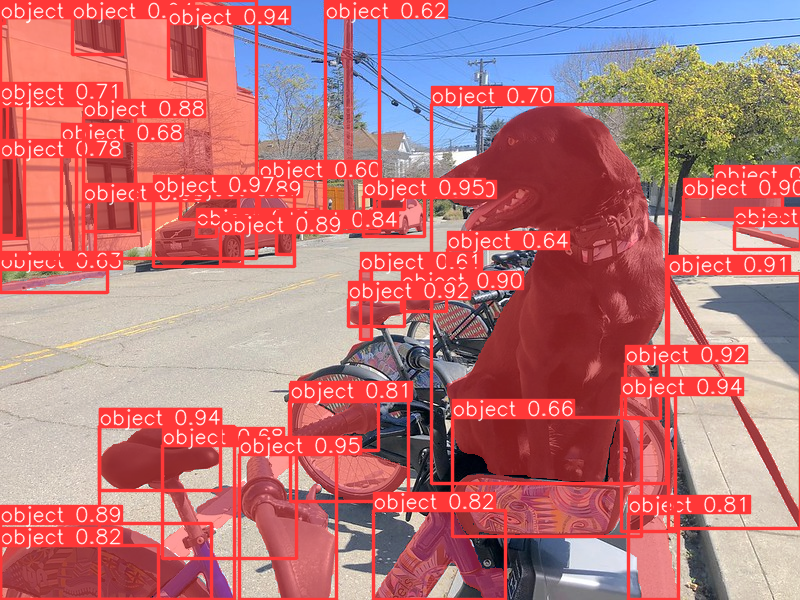

In [11]:
Image.fromarray(ov_results[0].plot()[..., ::-1])

## Optimize the model using NNCF Post-training Quantization API
[back to top ⬆️](#Table-of-contents:)


[NNCF](https://github.com/openvinotoolkit/nncf) provides a suite of advanced algorithms for Neural Networks inference optimization in OpenVINO with minimal accuracy drop.
We will use 8-bit quantization in post-training mode (without the fine-tuning pipeline) to optimize FastSAM.

The optimization process contains the following steps:

1. Create a Dataset for quantization.
2. Run `nncf.quantize` to obtain a quantized model.
3. Save the INT8 model using `openvino.save_model()` function.

In [12]:
do_quantize = widgets.Checkbox(
    value=True,
    description='Quantization',
    disabled=False,
)

do_quantize

Checkbox(value=True, description='Quantization')

The `nncf.quantize` function provides an interface for model quantization. It requires an instance of the OpenVINO Model and quantization dataset. 
Optionally, some additional parameters for the configuration quantization process (number of samples for quantization, preset, ignored scope, etc.) can be provided. YOLOv8 model backing FastSAM contains non-ReLU activation functions, which require asymmetric quantization of activations. To achieve a better result, we will use a `mixed` quantization preset. It provides symmetric quantization of weights and asymmetric quantization of activations. For more accurate results, we should keep the operation in the postprocessing subgraph in floating point precision, using the `ignored_scope` parameter.

The quantization algorithm is based on [The YOLOv8 quantization example](https://github.com/openvinotoolkit/nncf/tree/develop/examples/post_training_quantization/openvino/yolov8) in the NNCF repo, refer there for more details. Moreover, you can check out other quantization tutorials in the [OV notebooks repo](../yolov8-optimization/).

>**Note**: Model post-training quantization is time-consuming process. Be patient, it can take several minutes depending on your hardware.

In [15]:
%%skip not $do_quantize.value

import pickle
from contextlib import contextmanager
from zipfile import ZipFile

import cv2
from tqdm.autonotebook import tqdm

import nncf


COLLECT_CALIBRATION_DATA = False
calibration_data = []

@contextmanager
def calibration_data_collection():
    global COLLECT_CALIBRATION_DATA
    try:
        COLLECT_CALIBRATION_DATA = True
        yield
    finally:
        COLLECT_CALIBRATION_DATA = False


class NNCFWrapper:
    def __init__(self, ov_model, stride=32) -> None:
        self.model = core.read_model(ov_model)
        self.compiled_model = core.compile_model(self.model, device_name="CPU")

        self.stride = stride
        self.pt = False
        self.fp16 = False
        self.names = {0: "object"}

    def __call__(self, im, **_):
        if COLLECT_CALIBRATION_DATA:
            calibration_data.append(im)

        result = self.compiled_model(im)
        return torch.from_numpy(result[0]), torch.from_numpy(result[1])

# Fetch data from the web and descibe a dataloader
DATA_URL = "https://ultralytics.com/assets/coco128.zip"
OUT_DIR = Path('.')

download_file(DATA_URL, directory=OUT_DIR, show_progress=True)

if not (OUT_DIR / "coco128/images/train2017").exists():
    with ZipFile('coco128.zip', "r") as zip_ref:
        zip_ref.extractall(OUT_DIR)

class COCOLoader(torch.utils.data.Dataset):
    def __init__(self, images_path):
        self.images = list(Path(images_path).iterdir())

    def __getitem__(self, index):
        if isinstance(index, slice):
            return [self.read_image(image_path) for image_path in self.images[index]]
        return self.read_image(self.images[index])

    def read_image(self, image_path):
        image = cv2.imread(str(image_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image

    def __len__(self):
        return len(self.images)


def collect_calibration_data_for_decoder(model, calibration_dataset_size: int,
                                         calibration_cache_path: Path):
    global calibration_data


    if not calibration_cache_path.exists():
        coco_dataset = COCOLoader(OUT_DIR / 'coco128/images/train2017')
        with calibration_data_collection():
            for image in tqdm(coco_dataset[:calibration_dataset_size], desc="Collecting calibration data"):
                model(image, retina_masks=True, imgsz=1024, conf=0.6, iou=0.9, verbose=False)
        calibration_cache_path.parent.mkdir(parents=True, exist_ok=True)
        with open(calibration_cache_path, "wb") as f:
            pickle.dump(calibration_data, f)
    else:
        with open(calibration_cache_path, "rb") as f:
            calibration_data = pickle.load(f)

    return calibration_data


def quantize(model, save_model_path: Path, calibration_cache_path: Path,
             calibration_dataset_size: int, preset: nncf.QuantizationPreset):
    calibration_data = collect_calibration_data_for_decoder(
        model, calibration_dataset_size, calibration_cache_path)
    quantized_ov_decoder = nncf.quantize(
        model.predictor.model.model,
        calibration_dataset=nncf.Dataset(calibration_data),
        preset=preset,
        subset_size=len(calibration_data),
        fast_bias_correction=True,
        ignored_scope=nncf.IgnoredScope(
            types=["Multiply", "Subtract", "Sigmoid"],  # ignore operations
            names=[
                "/model.22/dfl/conv/Conv",  # in the post-processing subgraph
                "/model.22/Add",
                "/model.22/Add_1",
                "/model.22/Add_2",
            ],
        )
    )
    ov.save_model(quantized_ov_decoder, save_model_path)

wrapped_model = NNCFWrapper(ov_model_path, stride=model.predictor.model.stride)
model.predictor.model = wrapped_model

calibration_dataset_size = 128
quantized_model_path = Path(f"{model_name}_quantized") / "FastSAM-x.xml"
calibration_cache_path = Path(f"calibration_data/coco{calibration_dataset_size}.pkl")
if not quantized_model_path.exists():
    quantize(model, quantized_model_path, calibration_cache_path,
             calibration_dataset_size=calibration_dataset_size,
             preset=nncf.QuantizationPreset.MIXED)

'coco128.zip' already exists.
INFO:nncf:4 ignored nodes were found by name in the NNCFGraph
INFO:nncf:6 ignored nodes were found by types in the NNCFGraph
INFO:nncf:Not adding activation input quantizer for operation: 268 /model.22/Sigmoid
INFO:nncf:Not adding activation input quantizer for operation: 305 /model.22/dfl/conv/Conv
INFO:nncf:Not adding activation input quantizer for operation: 337 /model.22/Sub
INFO:nncf:Not adding activation input quantizer for operation: 338 /model.22/Add_1
INFO:nncf:Not adding activation input quantizer for operation: 348 /model.22/Add_2
358 /model.22/Div_1

INFO:nncf:Not adding activation input quantizer for operation: 349 /model.22/Sub_1
INFO:nncf:Not adding activation input quantizer for operation: 369 /model.22/Mul_2


Output()

Output()

### Compare the performance of the Original and Quantized Models
[back to top ⬆️](#Table-of-contents:)

Finally, we iterate both the OV model and the quantized model over the calibration dataset to measure the performance.

In [17]:
%%skip not $do_quantize.value

import datetime

coco_dataset = COCOLoader(OUT_DIR / 'coco128/images/train2017')
calibration_dataset_size = 128

wrapped_model = OVWrapper(ov_model_path, device=device.value, stride=model.predictor.model.stride)
model.predictor.model = wrapped_model

start_time = datetime.datetime.now()
for image in tqdm(coco_dataset, desc="Measuring inference time"):
    model(image, retina_masks=True, imgsz=1024, conf=0.6, iou=0.9, verbose=False)
duration_base = (datetime.datetime.now() - start_time).seconds
print("Segmented in", duration_base, "seconds.")
print("Resulting in", round(calibration_dataset_size / duration_base, 2), "fps")

Measuring inference time:   0%|          | 0/128 [00:00<?, ?it/s]

Segmented in 65 seconds.
Resulting in 1.97 fps


In [19]:
%%skip not $do_quantize.value

quantized_wrapped_model = OVWrapper(quantized_model_path, device=device.value, stride=model.predictor.model.stride)
model.predictor.model = quantized_wrapped_model

start_time = datetime.datetime.now()
for image in tqdm(coco_dataset, desc="Measuring inference time"):
    model(image, retina_masks=True, imgsz=1024, conf=0.6, iou=0.9, verbose=False)
duration_quantized = (datetime.datetime.now() - start_time).seconds
print("Segmented in", duration_quantized, "seconds")
print("Resulting in", round(calibration_dataset_size / duration_quantized, 2), "fps")
print("That is", round(duration_base / duration_quantized, 2), "times faster!")

Measuring inference time:   0%|          | 0/128 [00:00<?, ?it/s]

Segmented in 22 seconds
Resulting in 5.82 fps
That is 2.95 times faster!


## Try out the converted pipeline
[back to top ⬆️](#Table-of-contents:)

The demo app below is created using [Gradio package](https://www.gradio.app/docs/interface).

The app allows you to alter the model output interactively. Using the Pixel selector type switch you can place foreground/background points or bounding boxes on input image.

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def fast_process(
    annotations,
    image,
    scale,
    better_quality=False,
    mask_random_color=True,
    bbox=None,
    use_retina=True,
    with_contours=True,
):

    original_h = image.height
    original_w = image.width

    if better_quality:
        for i, mask in enumerate(annotations):
            mask = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8))
            annotations[i] = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_OPEN, np.ones((8, 8), np.uint8))

    inner_mask = fast_show_mask(
        annotations,
        plt.gca(),
        random_color=mask_random_color,
        bbox=bbox,
        retinamask=use_retina,
        target_height=original_h,
        target_width=original_w,
    )

    if with_contours:
        contour_all = []
        temp = np.zeros((original_h, original_w, 1))
        for i, mask in enumerate(annotations):
            annotation = mask.astype(np.uint8)
            if not use_retina:
                annotation = cv2.resize(
                    annotation,
                    (original_w, original_h),
                    interpolation=cv2.INTER_NEAREST,
                )
            contours, _ = cv2.findContours(annotation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            for contour in contours:
                contour_all.append(contour)
        cv2.drawContours(temp, contour_all, -1, (255, 255, 255), 2 // scale)
        color = np.array([0 / 255, 0 / 255, 255 / 255, 0.9])
        contour_mask = temp / 255 * color.reshape(1, 1, -1)

    image = image.convert("RGBA")
    overlay_inner = Image.fromarray((inner_mask * 255).astype(np.uint8), "RGBA")
    image.paste(overlay_inner, (0, 0), overlay_inner)

    if with_contours:
        overlay_contour = Image.fromarray((contour_mask * 255).astype(np.uint8), "RGBA")
        image.paste(overlay_contour, (0, 0), overlay_contour)

    return image


# CPU post process
def fast_show_mask(
    annotation,
    ax,
    random_color=False,
    bbox=None,
    retinamask=True,
    target_height=960,
    target_width=960,
):
    mask_sum = annotation.shape[0]
    height = annotation.shape[1]
    weight = annotation.shape[2]
    # 
    areas = np.sum(annotation, axis=(1, 2))
    sorted_indices = np.argsort(areas)[::1]
    annotation = annotation[sorted_indices]

    index = (annotation != 0).argmax(axis=0)
    if random_color:
        color = np.random.random((mask_sum, 1, 1, 3))
    else:
        color = np.ones((mask_sum, 1, 1, 3)) * np.array([30 / 255, 144 / 255, 255 / 255])
    transparency = np.ones((mask_sum, 1, 1, 1)) * 0.6
    visual = np.concatenate([color, transparency], axis=-1)
    mask_image = np.expand_dims(annotation, -1) * visual

    mask = np.zeros((height, weight, 4))

    h_indices, w_indices = np.meshgrid(np.arange(height), np.arange(weight), indexing="ij")
    indices = (index[h_indices, w_indices], h_indices, w_indices, slice(None))

    mask[h_indices, w_indices, :] = mask_image[indices]
    if bbox is not None:
        x1, y1, x2, y2 = bbox
        ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor="b", linewidth=1))

    if not retinamask:
        mask = cv2.resize(mask, (target_width, target_height), interpolation=cv2.INTER_NEAREST)

    return mask

In [21]:
import gradio as gr

examples = [[image_uri], ["https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/empty_road_mapillary.jpg"],
            ["https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/wall.jpg"]]

object_points = []
background_points = []
bbox_points = []
last_image = examples[0][0]

This is the main callback function that is called to segment an image based on user input.

In [22]:
def segment(
        image,
        model_type,
        input_size=1024, 
        iou_threshold=0.75,
        conf_threshold=0.4,
        better_quality=True,
        with_contours=True,
        use_retina=True,
        mask_random_color=True,
):
    if do_quantize.value and model_type == 'Quantized model':
        model.predictor.model = quantized_wrapped_model
    else:
        model.predictor.model = wrapped_model
    
    input_size = int(input_size)
    w, h = image.size
    scale = input_size / max(w, h)
    new_w = int(w * scale)
    new_h = int(h * scale)
    image = image.resize((new_w, new_h))

    results = model(image,
                    retina_masks=use_retina,
                    iou=iou_threshold,
                    conf=conf_threshold,
                    imgsz=input_size,)

    masks = results[0].masks.data
    # Calculate annotations
    if not (object_points or bbox_points):
        annotations = masks.cpu().numpy()
    else:
        annotations = []

    if object_points:
        all_points = object_points + background_points
        labels = [1] * len(object_points) + [0] * len(background_points)
        scaled_points = [[int(x * scale) for x in point] for point in all_points]
        h, w = masks[0].shape[:2]
        assert max(h, w) == input_size
        onemask = np.zeros((h, w))
        for mask in sorted(masks, key=lambda x: x.sum(), reverse=True):
            mask_np = (mask == 1.0).cpu().numpy()
            for point, label in zip(scaled_points, labels):
                if mask_np[point[1], point[0]] == 1 and label == 1:
                    onemask[mask_np] = 1
                if mask_np[point[1], point[0]] == 1 and label == 0:
                    onemask[mask_np] = 0
        annotations.append(onemask >= 1)
    if len(bbox_points) >= 2:
        scaled_bbox_points = []
        for i, point in enumerate(bbox_points):
            x, y = int(point[0] * scale), int(point[1] * scale)
            x = max(min(x, new_w), 0)
            y = max(min(y, new_h), 0)
            scaled_bbox_points.append((x, y))

        for i in range(0, len(scaled_bbox_points) - 1, 2):
            x0, y0, x1, y1 = *scaled_bbox_points[i], *scaled_bbox_points[i + 1]
            
            intersection_area = torch.sum(masks[:, y0:y1, x0:x1], dim=(1, 2))
            masks_area = torch.sum(masks, dim=(1, 2))
            bbox_area = (y1 - y0) * (x1 - x0)

            union = bbox_area + masks_area - intersection_area
            iou = intersection_area / union
            max_iou_index = torch.argmax(iou)

            annotations.append(masks[max_iou_index].cpu().numpy())

    return fast_process(
        annotations=np.array(annotations),
        image=image,
        scale=(1024 // input_size),
        better_quality=better_quality,
        mask_random_color=mask_random_color,
        bbox=None,
        use_retina=use_retina,
        with_contours=with_contours
    )

In [ ]:
def select_point(img: Image.Image, point_type: str, evt: gr.SelectData) -> Image.Image:
    """Gradio select callback."""
    img = img.convert("RGBA")
    x, y = evt.index[0], evt.index[1]
    point_radius = np.round(max(img.size) / 100)
    if point_type == "Object point":
        object_points.append((x, y))
        color = (30, 255, 30, 200)
    elif point_type == "Background point":
        background_points.append((x, y))
        color = (255, 30, 30, 200)
    elif point_type == "Bounding Box":
        bbox_points.append((x, y))
        color = (10, 10, 255, 255)
        if len(bbox_points) % 2 == 0:
            # Draw a rectangle if number of points is even
            new_img = Image.new("RGBA", img.size, (255, 255, 255, 0))
            _draw = ImageDraw.Draw(new_img)
            x0, y0, x1, y1 = *bbox_points[-2], *bbox_points[-1]
            x0, x1 = sorted([x0, x1])
            y0, y1 = sorted([y0, y1])
            # Save sorted order
            bbox_points[-2] = (x0, y0)
            bbox_points[-1] = (x1, y1)
            _draw.rectangle((x0, y0, x1, y1), fill=(*color[:-1], 90))
            img = Image.alpha_composite(img, new_img)
    # Draw a point
    ImageDraw.Draw(img).ellipse(
        [(x - point_radius, y - point_radius), (x + point_radius, y + point_radius)],
        fill=color
    )
    return img

def clear_points() -> (Image.Image, None):
    """Gradio clear points callback."""
    global object_points, background_points, bbox_points
    # global object_points; global background_points; global bbox_points
    object_points = []
    background_points = []
    bbox_points = []
    return last_image, None

def save_last_picked_image(img: Image.Image) -> None:
    """Gradio callback saves the last used image."""
    global last_image
    last_image = img
    # If we change the input image
    # we should clear all the previous points
    clear_points()
    # Removes the segmentation map output
    return None

with gr.Blocks(title="Fast SAM") as demo:
    with gr.Row(variant="panel"):
        original_img = gr.Image(label="Input", value=examples[0][0], type="pil")
        segmented_img = gr.Image(label="Segmentation Map", type="pil")
    with gr.Row():
        point_type = gr.Radio(
            ["Object point", "Background point", "Bounding Box"],
            value="Object point", label="Pixel selector type"
        )
        model_type = gr.Radio(
            ["FP32 model", "Quantized model"] if do_quantize.value else ["FP32 model"],
            value="FP32 model", label="Select model variant"
        )
    with gr.Row(variant="panel"):
        segment_button = gr.Button("Segment", variant="primary")
        clear_button = gr.Button("Clear points", variant="secondary")
    gr.Examples(examples, inputs=original_img,
                fn=save_last_picked_image, run_on_click=True, outputs=segmented_img
    )

    # Callbacks
    original_img.select(select_point,
                        inputs=[original_img, point_type],
                        outputs=original_img)
    original_img.upload(save_last_picked_image, inputs=original_img, outputs=segmented_img)
    clear_button.click(clear_points, outputs=[original_img, segmented_img])
    segment_button.click(segment, inputs=[original_img, model_type], outputs=segmented_img)

try:
    demo.queue().launch(debug=True)
except Exception:
    demo.queue().launch(share=True, debug=True)

# If you are launching remotely, specify server_name and server_port
# EXAMPLE: `demo.launch(server_name="your server name", server_port="server port in int")`
# To learn more please refer to the Gradio docs: https://gradio.app/docs/